In [17]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import multiprocessing

Neste projeto, implementamos o método de buscas em redes proposto na referência:
DOI: https://doi.org/10.1103/PhysRevE.86.056110

Neste caso estamos fazendo a parte computacional, visto que no artigo, os resultados são analíticos.

O método proposto por Riascos consite em uma generalização das caminhadas de lévy para redes complexas. Ele cria um modelo de navegação de longo alcance onde a probabilidade de um nó ser visitado depende uma distribuição power-law. 

Basicamente, temos um alvo numa posição aleatória da rede que deve ser encontrado. O objetivo é encontrar a melhor estratégia de modo que a busca torne-se mais eficiente. 

Este modelo pode ser aplicado em fenômenos de transporte, propagação de informação, mobilidade...

In [18]:
# Função que conta os links de cada nó da rede

def contar_link(rede): 
    N = np.max(rede) + 1 # N é números de nós da rede 
    links = np.zeros(N) # a entrada do array tem a quantidade de link do nó correspondente a entrada
    for l in rede:
        for n in l:
            links[n] += 1
    return links
    


In [19]:
# Função que cria a lista de adjacencias de uma rede

def adjacencia(rede):

    graus = contar_link(rede)

    t_lista = int(np.sum(graus))

    lista_adj = np.zeros(t_lista)


    n_max = np.max(rede) # quantidade de nós

    i = 0 # índice lista adjacências
    for n in range(n_max + 1):
        for k in range(len(rede)):
            no_1 = rede[k][0]
            no_2 = rede[k][1]

            if no_1 == n:
                lista_adj[i] = no_2
                i += 1

            if no_2 == n:
                lista_adj[i] = no_1
                i +=1
                
                
    return lista_adj



In [20]:
# Função que retorna o vizinhos de um nó

def vizinho_no(n, graus_rede, lista_adj_rede): # n representa o nó
    
    
    inicio = 0
    for t in range(int(n)):
        inicio += int(graus_rede[t])
        
        
    n_vizinhos = int(graus_rede[n])
        
    lista_vizinhos_no = np.zeros(n_vizinhos)
    
    
    for j in range(n_vizinhos):
        lista_vizinhos_no[j] = lista_adj_rede[inicio]
        inicio += 1
    
    return lista_vizinhos_no
    
    

In [21]:
# Função que verifica se um determinado nó pertence à uma lista
# se pertencer, a função retorna -1
# se não pertencer, a função retorna -2

def verifica(no_dado, lista):
    for no in lista:
        if no == no_dado:
            return -1
    return -2




In [22]:
### Função que calcula o comprimento do caminho mais curto entre o no_i e o no_j 
# usando o metodo BFS
## também retorna a 'queue'

def menor_distancia(no_i, no_j, lista_adj, graus_rede):
    no_i = int(no_i)
    no_j = int(no_j)
    
    queue = [[no_i]]
    visitados = [no_i]

    while True:
        ultimos = queue[-1]  # camada atual
        # Verifica se o nó destino está nessa camada
        if verifica(no_j, ultimos) != -2:
            break

        vizinhos = []
        for no in ultimos:
            no = int(no) 
            v_no = vizinho_no(no, graus_rede, lista_adj)
            for n in v_no:
                n = int(n)  
                if verifica(n, visitados) == -2:
                    vizinhos.append(n)
                    visitados.append(n)

        queue.append(vizinhos)

    j = len(queue) - 1  # comprimento do caminho
    return int(j), queue



In [23]:
### Função que retorna a matriz distância D da rede

def Matriz_D(N, lista_adj, graus_rede):
    D = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            d, Q = menor_distancia(i, j, lista_adj, graus_rede)
            if i == j:
                D[i, j] = 0
            else:
                D[i, j] = d
                D[j, i] = d
    return D


In [24]:
### função que calcula a distância de um nó para outro a partir da matriz D

def distancia_ij(no_i, no_j, matriz_D):
    d_ij = matriz_D[no_i, no_j]
    return int(d_ij)


In [25]:
#### Função que calcula o peso de cada nó a ser sorteado quando estamos no nó i

def peso_nos(n_i, matriz_D, lista_adj, graus_rede, N, alpha):
    D = matriz_D
    #calcula o somatório
    somatorio = 0
    distancias_no = D[n_i]
    for d in distancias_no:
        if d != 0:
            somatorio += d**(-alpha)
        
    # guarda o peso que cada nó tem de ser visitado    
    pesos = np.random.rand(N)
    for j in range(N):
        d_ij = distancias_no[j]
        if d_ij != 0:
            pesos[j] = (d_ij**(-alpha)) / somatorio
        else:
            pesos[j] = 0
    
    return pesos 




In [26]:
def sorteio_no(n_i, matriz_D, lista_adj, graus_rede, N, alpha):
    pesos = peso_nos(n_i, matriz_D, lista_adj, graus_rede, N, alpha)
    acumulado = np.zeros(N)
    for i in range(N):
        acumulado[i] = pesos[i] if i == 0 else acumulado[i - 1] + pesos[i]
        
    r = np.random.rand() * acumulado[-1]

    no_sorteado = 0
    for i in range(N):
        if r <= acumulado[i]:
            no_sorteado = i
            break

    return no_sorteado



In [27]:
### Função que retorna tempo gasto para sair do nó de partida até o nó alvo

def fpt(no_partida, no_alvo, graus_rede, lista_adj, alpha, matriz_D, N):
    
    tempo = 0
    N_i = int(no_partida)
    N_a = int(no_alvo)
    
    V = N_i # último nó visitado
    no_s = -2
    
    #VISITADOS = [N_i]
    
    while no_s != N_a:
        no_sorteado = sorteio_no(V, matriz_D, lista_adj, graus_rede, N, alpha)
        if no_sorteado == N_a:
            no_s = N_a  # ATUALIZA antes de sair
            break
        no_s = no_sorteado
        V = no_s  # Atualiza o último nó visitado
        tempo += 1
        
    return tempo




In [28]:
# função que calcula tau_i

# tau_i =====>>> tempo médio de alcançar o nó i partindo de um nó aleatório da rede

def Tau_i(no_alvo, graus_rede, lista_adj, alpha, matriz_D, N, N_tau_i):
    TAU_i = 0
    for i in range(N_tau_i):
        no_partida = int(np.random.randint(N))
        tempo = fpt(no_partida, no_alvo, graus_rede, lista_adj, alpha, matriz_D, N)
        TAU_i += tempo
    tau_i = TAU_i / N_tau_i
    return tau_i



In [29]:
#  Função que calcula MFPT (tempo global de primeira passagem do Ryascos)

def MFPT(alpha):
   
    diametro = int(N)
    N_tau_i = 50 * N  # Número de vezes que será calculado o tempo médio até cada nó-alvo

    
    TAU = 0
    for t in range(N):
        no_alvo = int(t)
        tau_i = Tau_i(no_alvo, graus_rede, lista_adj, alpha, matriz_D, N, N_tau_i)
        TAU += tau_i

    return TAU / N

In [30]:
#### Vamos testar na rede Barabási 

# Função que pega apenas a parte "útil" de uma matriz
def particiona(matriz, indice):
    matriz_particionada = np.zeros((indice, 2), dtype=matriz.dtype)
    
    for i in range(indice):
        matriz_particionada[i] = matriz[i]
        
    return matriz_particionada



# costrói a rede Barabási-Albert
def Barabasi_Albert(N): 
    C = int(2 * (N - 2) + 1)  # número de conexões

    # Inicializando com zeros e depois preenchendo a rede inicial
    rede_total_p = np.zeros((C + 1, 2), dtype=np.int64)  # C + 1 para garantir espaço suficiente
    rede_total_p[0] = [0, 1]  # rede inicial com apenas dois nós
    
    t_p = int(2 + 4 * (N - 2))
    
    possibilidades = np.zeros(t_p)
    possibilidades[0] = 0
    possibilidades[1] = 1
    
    
    n = 2  # Próximo nó a ser adicionado
    i = 1  # Índice para preencher rede_total_p, começando após a rede inicial
    p = 2  # Índice para preencher possibilidades

    for _ in range(1, N - 1):
        rede = particiona(rede_total_p, i)
        
        s1 = np.random.randint(p)
        s2 = np.random.randint(p)
        
        N1 = possibilidades[s1]  # 1º nó sorteado
        N2 = possibilidades[s2]   # 2º nó sorteado
        while N2 == N1:
            s2 = np.random.randint(p)
            N2 = possibilidades[s2] 

        # Preenchendo a matriz com as novas conexões
        rede_total_p[i] = [n, N1]
        rede_total_p[i + 1] = [n, N2]
        
        possibilidades[p] = n
        possibilidades[p + 1] = n
        possibilidades[p + 2] = N1
        possibilidades[p + 3] = N2
        
        
        n += 1
        i += 2
        p += 4

    return particiona(rede_total_p, i)  # Retornando apenas a parte preenchida da matriz






In [31]:
%%time


# Cria a rede uma única vez

N = 30

rede_barabasi = Barabasi_Albert(N)
graus_rede = contar_link(rede_barabasi)
lista_adj = adjacencia(rede_barabasi)
matriz_D = Matriz_D(N, lista_adj, graus_rede)


if __name__ == '__main__':
    
    ALPHA = np.linspace(0.1, 10.0, 25)  # Lista de parâmetros

    # Cria um pool de processos com o número máximo de processos desejado
    pool = multiprocessing.Pool()

    # Mapeia os parâmetros para a função usando o pool de processos
    tau_todos_alphas = pool.map(MFPT, ALPHA)

    # Fecha o pool de processos para liberar os recursos
    pool.close()
    pool.join()

    # Os resultados estarão na mesma ordem dos parâmetros na lista


CPU times: user 169 ms, sys: 27.2 ms, total: 196 ms
Wall time: 3min 50s


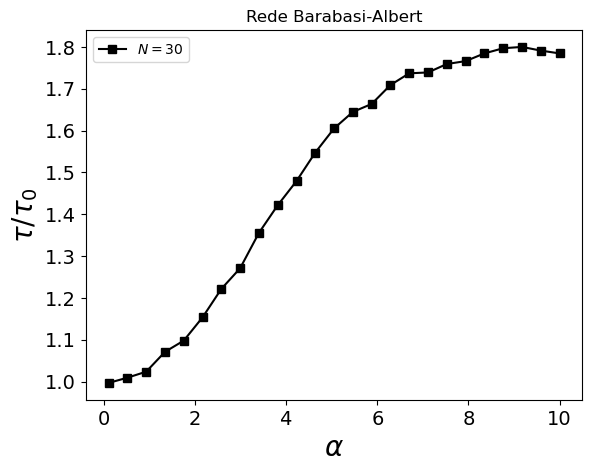

In [32]:
tau_0 = ((N - 1)**2) / N

plt.plot(ALPHA, np.array(tau_todos_alphas) / tau_0, 'ks-', label = rf'$N = {N}$')
plt.xlabel(r'$\alpha$', fontsize = 20)
plt.ylabel(r'$\tau / \tau_{0}$', fontsize = 20)
#plt.xticks(np.arange(0.1, 2.0, 0.2))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('Rede Barabasi-Albert')
plt.legend()
plt.show()


O resultado mostrado acima corresponde aos resultados mostrados no paper. Logo, tivemos sucesso ao implementar o método. Como podemos observar, em alpha = 0 o tempo de busca é minimizado, mostrando-se ser o mais eficiente. 